In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()

to_device_collate_configurable = partial(to_device_collate, config.device)

training_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"training_dataset : {len(training_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

train_batch_repeat_sampler = EpisodeBatchRepeatSampler(
    dataset=training_dataset,
    batch_size=config.train_batch_size,
    repeats=config.episode_steps,
)
print(f"train_batch_repeat_sampler: {list(train_batch_repeat_sampler)}")

train_dataloader = DataLoader(
    training_dataset,
    batch_size=config.train_batch_size,
    sampler=train_batch_repeat_sampler,
    collate_fn=to_device_collate_configurable,
)
test_dataloader = DataLoader(
    test_dataset, batch_size=2, collate_fn=to_device_collate_configurable
)

training_dataset : 10000
test_dataset : 2000
train_batch_repeat_sampler: [4369, 8817, 112, 666, 7533, 6073, 2988, 5898, 2417, 3527, 2476, 581, 892, 4250, 2412, 3825, 1561, 2870, 4352, 9088, 472, 6348, 8514, 4082, 6087, 282, 1267, 8289, 6369, 3404, 8654, 173, 5488, 3425, 1557, 1959, 9303, 4209, 9867, 7386, 519, 7521, 2750, 4992, 4892, 4311, 9522, 1078, 7165, 5051, 4369, 8817, 112, 666, 7533, 6073, 2988, 5898, 2417, 3527, 2476, 581, 892, 4250, 2412, 3825, 1561, 2870, 4352, 9088, 472, 6348, 8514, 4082, 6087, 282, 1267, 8289, 6369, 3404, 8654, 173, 5488, 3425, 1557, 1959, 9303, 4209, 9867, 7386, 519, 7521, 2750, 4992, 4892, 4311, 9522, 1078, 7165, 5051, 4369, 8817, 112, 666, 7533, 6073, 2988, 5898, 2417, 3527, 2476, 581, 892, 4250, 2412, 3825, 1561, 2870, 4352, 9088, 472, 6348, 8514, 4082, 6087, 282, 1267, 8289, 6369, 3404, 8654, 173, 5488, 3425, 1557, 1959, 9303, 4209, 9867, 7386, 519, 7521, 2750, 4992, 4892, 4311, 9522, 1078, 7165, 5051, 4369, 8817, 112, 666, 7533, 6073, 2988, 5898, 2417

fov: torch.Size([11, 11])


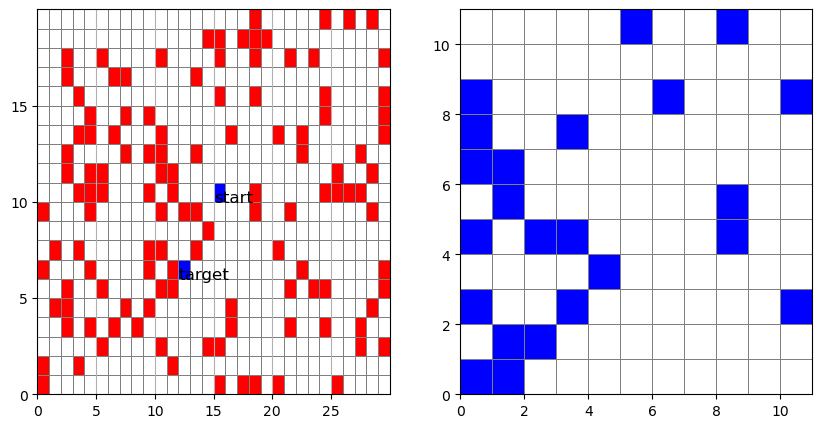

In [3]:
episode1 = training_dataset.episodes[0]

# Viz world
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
episode1.viz(ax=axes[0])

# Viz fov
fov = episode1.world.fov(center_pos=episode1.agent.start_state.position())
print(f"fov: {fov.size()}")
# print(f"fov: {fov}")
episode1.world.viz_fov(center_pos=episode1.agent.start_state.position(), ax=axes[1])
plt.show()

In [4]:
def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    # print(f"start state: {episode.agent.start_state}")
    # print(f"target state: {episode.agent.target_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    # print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, color=get_color(0))
    plt.show()

    return episode

step: 0, logits: tensor([[ 0.1623,  0.5491, -0.0043,  0.1438, -0.1989, -1.1360, -0.0738,  0.5803,
          0.2963]]), logit_prob: tensor([[0.1474]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([0.5333, 0.5000])
step: 1, logits: tensor([[-0.2167,  0.7288,  0.7385,  0.7345,  0.4462, -0.3710, -0.3300,  0.3256,
         -0.8627]]), logit_prob: tensor([[0.1532]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([0.5000, 0.5500])
step: 2, logits: tensor([[-0.1543, -0.6531,  0.7122,  0.1820,  0.0339,  0.3625, -0.1416, -0.2696,
         -0.3743]]), logit_prob: tensor([[0.1841]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([0.4667, 0.6000])
step: 3, logits: tensor([[-0.7408,  0.7043,  0.7648,  0.6406,  0.0265, -0.5518, -0.3067,  0.0298,
         -0.4619]]), logit_prob: tensor([[0.1716]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([0.4333, 0.6500])
step: 4, logits: tensor([[-0.8878,  0.8673,  0.8

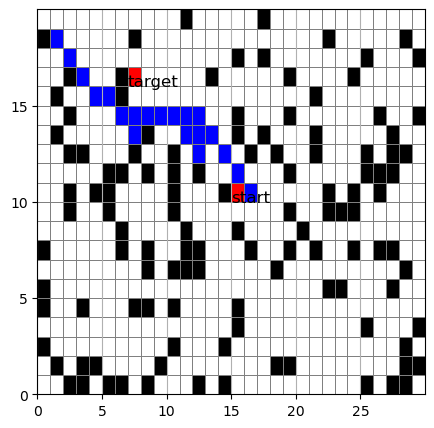

In [5]:
policy = Policy(config=config)
episode = inference_and_plot_policy(policy=policy, debug=True)
# episode.agent.action_history

# Training Loop
---

In [6]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

In [7]:
trainer.train(dataset=training_dataset, debug=False)

train_batch_repeat_sampler: [8157, 562, 9173, 2702, 1244, 7705, 3853, 3184, 884, 2787, 261, 3298, 4366, 178, 4924, 1879, 3353, 8607, 8872, 7383, 9464, 6376, 8931, 9510, 7255, 4988, 9085, 3160, 8189, 1465, 2286, 5370, 3216, 8117, 2190, 2967, 5395, 4467, 1394, 3340, 1999, 1588, 4146, 8224, 4343, 604, 5672, 2193, 5530, 4112, 8157, 562, 9173, 2702, 1244, 7705, 3853, 3184, 884, 2787, 261, 3298, 4366, 178, 4924, 1879, 3353, 8607, 8872, 7383, 9464, 6376, 8931, 9510, 7255, 4988, 9085, 3160, 8189, 1465, 2286, 5370, 3216, 8117, 2190, 2967, 5395, 4467, 1394, 3340, 1999, 1588, 4146, 8224, 4343, 604, 5672, 2193, 5530, 4112, 8157, 562, 9173, 2702, 1244, 7705, 3853, 3184, 884, 2787, 261, 3298, 4366, 178, 4924, 1879, 3353, 8607, 8872, 7383, 9464, 6376, 8931, 9510, 7255, 4988, 9085, 3160, 8189, 1465, 2286, 5370, 3216, 8117, 2190, 2967, 5395, 4467, 1394, 3340, 1999, 1588, 4146, 8224, 4343, 604, 5672, 2193, 5530, 4112, 8157, 562, 9173, 2702, 1244, 7705, 3853, 3184, 884, 2787, 261, 3298, 4366, 178, 4924, 

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


step: 0, logits: tensor([[ 4.2925e+04,  3.6410e+03,  3.7629e+04,  4.6488e+04,  1.7845e+03,
         -2.3059e+06,  2.7167e+04,  5.6436e+04,  3.8627e+04]], device='mps:0'), logit_prob: tensor([[0.1207]], device='mps:0'), top_k_prob: tensor([[1.]], device='mps:0'), action_idx: tensor([[7]], device='mps:0'), state: tensor([0.5333, 0.5000])
step: 1, logits: tensor([[ 4.0531e+04,  3.4339e+03,  3.5149e+04,  4.3752e+04,  1.4782e+03,
         -2.1772e+06,  2.5968e+04,  5.3525e+04,  3.6396e+04]], device='mps:0'), logit_prob: tensor([[0.1207]], device='mps:0'), top_k_prob: tensor([[1.]], device='mps:0'), action_idx: tensor([[7]], device='mps:0'), state: tensor([0.5667, 0.5000])
step: 2, logits: tensor([[ 3.9629e+04,  3.3150e+03,  3.4849e+04,  4.3151e+04,  1.6932e+03,
         -2.1310e+06,  2.5329e+04,  5.2400e+04,  3.5819e+04]], device='mps:0'), logit_prob: tensor([[0.1207]], device='mps:0'), top_k_prob: tensor([[1.]], device='mps:0'), action_idx: tensor([[7]], device='mps:0'), state: tensor([0.6

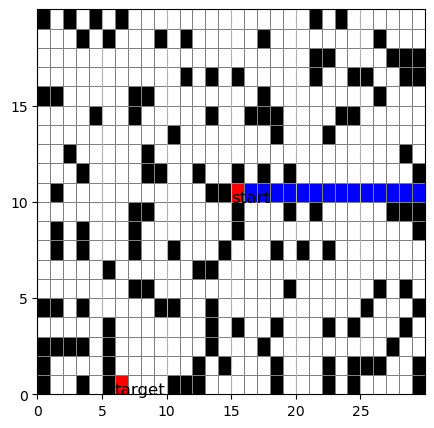

episode reward: -32.24485778808594


In [8]:
episode = inference_and_plot_policy(policy=policy, debug=True)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")